## Importing the libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the dataset

In [2]:
data = pd.read_csv('data.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
data.shape

(6362620, 11)

## Data Visualization

<Axes: xlabel='type', ylabel='count'>

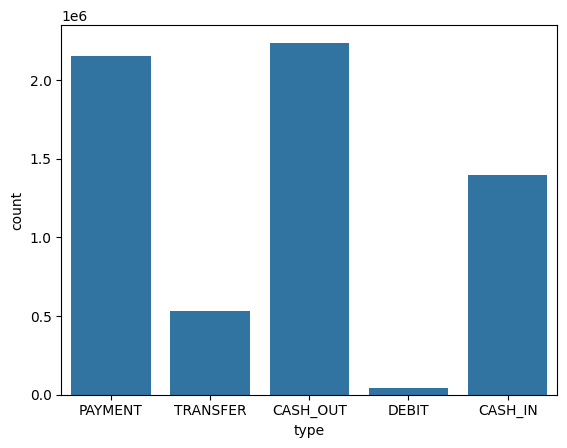

In [4]:
sns.countplot(x='type', data=data)

<Axes: xlabel='type', ylabel='amount'>

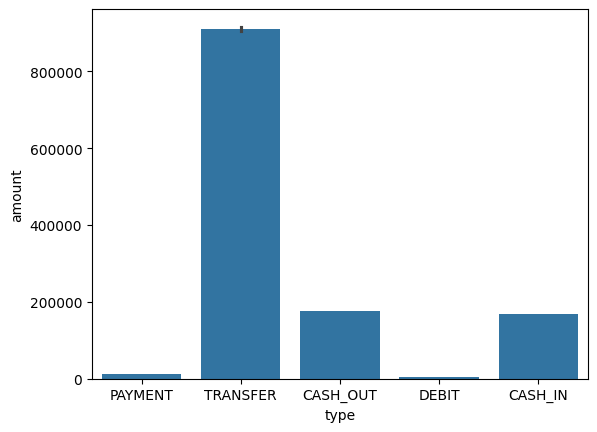

In [5]:
sns.barplot(x='type', y='amount', data=data)

Both the graph clearly shows that mostly the type cash_out and transfer are maximum in count and as well as in amount. 

In [6]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [7]:
fraud_percentage = (data['isFraud'].sum() / len(data)) * 100
print(f"Fraud percentage: {fraud_percentage:.4f}%")

Fraud percentage: 0.1291%


<Axes: >

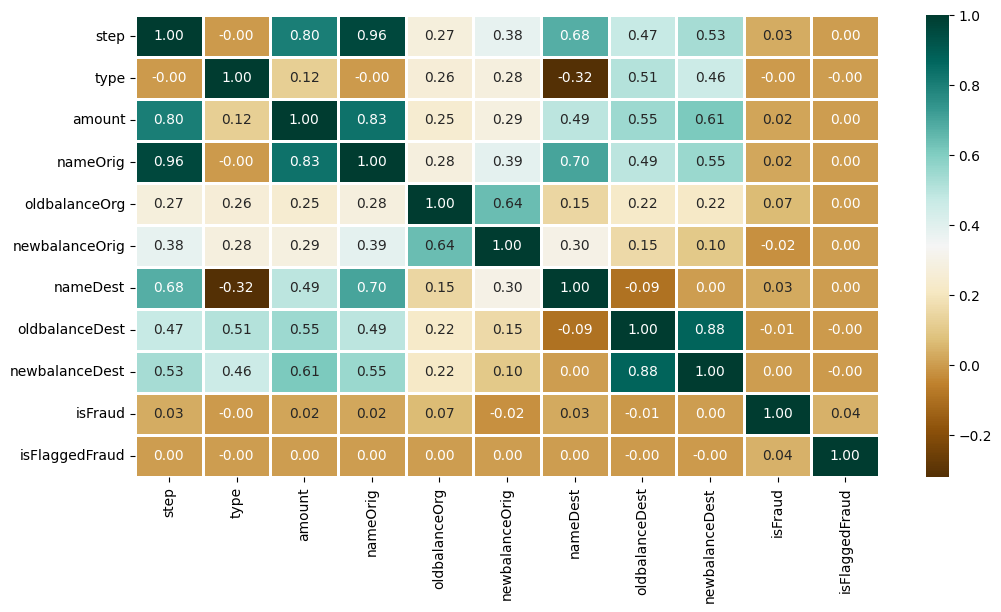

In [8]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.apply(lambda x: pd.factorize(x)[0]).corr(),
			cmap='BrBG',
			fmt='.2f',
			linewidths=2,
			annot=True)

## Data Preprocessing

In [15]:
type_columns = pd.get_dummies(data["type"], drop_first=True)
data = pd.concat([data, type_columns], axis=1)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,False,False,True,False
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,False,False,True,False
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,False,False,True
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,True,False,False,False
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,False,False,True,False


In [16]:
X = data.drop(["type", "isFraud", "nameOrig", "nameDest", "isFlaggedFraud"], axis=1)
y = data["isFraud"]

In [17]:
X.shape, y.shape

((6362620, 10), (6362620,))

# Feature Scaling

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

numeric_columns = ["amount", "oldbalanceOrg" , "newbalanceOrig", "oldbalanceDest" , "newbalanceDest"]

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

## Model Training

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [32]:
models = [LogisticRegression(max_iter=1000), XGBClassifier(), RandomForestClassifier(n_estimators=7, criterion="entropy")]

for i in range(len(models)):
    models[i].fit(X_train, y_train)

    y_train_preds = models[i].predict(X_train)
    y_test_preds = models[i].predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_preds)
    test_accuracy = accuracy_score(y_test, y_test_preds)

    print(f'{models[i]}: ')

    print(f"Train Accuracy : {train_accuracy}")
    print(f"Test Accuracy : {test_accuracy}")
    print()

LogisticRegression(max_iter=1000): 
Train Accuracy : 0.9991914831132009
Test Accuracy : 0.9992026345541093

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...): 
Train Accuracy : 0.9998572016828647
Test Accuracy : 0.9997663436341214

RandomForestClassifier(criterion='entropy', n_estimators=7):

## Model Evaluation

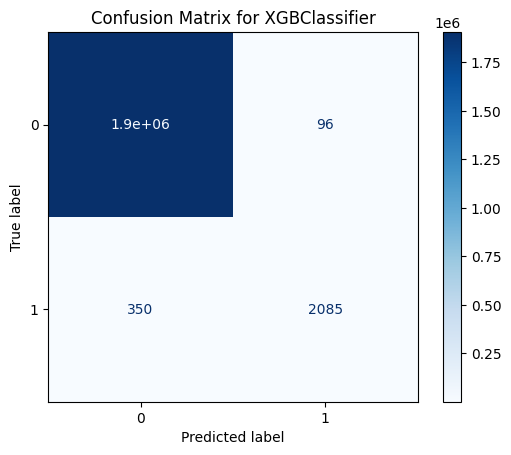

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

y_test_preds = models[1].predict(X_test)

cm = confusion_matrix(y_test, y_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for XGBClassifier")
plt.show()

In [36]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.96      0.86      0.90      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.93      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786

